# Propagation des incertitudes

On considère dans cet exemple un modèle simple dans lequel on probabilise $A_s$, $F$, $\tau_c$. Le nombre de cotisants $N_C$ et les autres dépenses de retraites $dP$ sont calculés en fonction du taux de chômage $\tau_c$ par interpolation linéaire entre le scénario optimiste (taux de chômage 4.5%) et le scénario pessimiste (10 %). Cette modélisation est une approximation si le scénario associé à un taux de chômage de 7% n'est pas au centre des deux scénarios extrêmes. 

In [1]:
from retraites.SimulateurRetraites import SimulateurRetraites
import openturns as ot
import pylab as pl

## Définition des paramètres

In [2]:
simulateur = SimulateurRetraites()

## Définition du modèle physique

In [3]:
def calculePension(X):
    """
    Calcule la pension en fonction du solde S, 
    des dépenses D et de l'âge de départ en retraite As.
    
    Paramètres
    As : l'âge de départ à la retraite de l'utilisateur
    F : facteur d'élasticité (par défaut, F = 0.5)
    TauC : taux de chômage (%)
    S : le solde financier
    D : le montant des dépenses de retraite en part de PIB
    B : part des revenus d'activités bruts dans le PIB
    G : Effectif moyen d'une génération arrivant aux âges de la retraite
    A : âge moyen de départ à la retraite du COR
    NR : Nombre de retraités de droit direct (tous régimes confondus)
    TauC1 : taux de chômage (%) à la date t1
    TauC2 : Idem à la date t2
    NC1 : Nombre de cotisants pour le taux TauC1
    NC2 : Idem pour le taux TauC1
    dP1 : Autres dépenses de retraite rapportées au nombre de retraités 
          de droit direct en % du revenu d'activités brut moyen
          pour le taux TauC1
    dP2 : Idem pour le taux TauC1
    
    Description
    Retourne 
    P : niveau des pensions par rapport aux salaires
    
    Si l’utilisateur renseigne un âge effectif moyen de départ 
    à la retraite plus élevé que celui
    qui découle de l’évolution spontanée à législation inchangée 
    (c’est-à-dire si As>A), le nombre de
    retraités est donc diminué de G x (As – A) et le nombre 
    de cotisants augmenté de + E x G x (As – A).
    
    Le calcul utilise la variable NC :
    NC : Nombre de personnes en emploi (ou nombre de cotisants)

    """
    As, F, TauC, S, D, B, G, A, NR, TauC1, TauC2, NC1, NC2, dP1, dP2 = X
    # Interpolation linéaire
    NC = (TauC2 - TauC) * NC1 / (TauC2 - TauC1) + (TauC - TauC1) * NC2 / (TauC2 - TauC1)
    dP = (TauC2 - TauC) * dP1 / (TauC2 - TauC1) + (TauC - TauC1) * dP2 / (TauC2 - TauC1)
    # Coeur du modèle
    T = (S + D) / B
    g = G * (As - A)
    K = (NR - g) / (NC + F * g)
    P = (T - S / B) / K - dP
    # Résultats intermédiaires
    verbose = False
    if verbose:
        print("NC =", NC)
        print("T =", T)
        print("g =", g)
        print("K =", K)
        print("P =", P)
    Y = [P]
    return Y

In [4]:
# Paramètres
scenario_central = simulateur.scenario_central
scenario_optimiste = simulateur.scenario_optimiste
scenario_pessimiste = simulateur.scenario_pessimiste
simulateur.scenarios_labels[scenario_central], \
simulateur.scenarios_labels[scenario_optimiste], \
simulateur.scenarios_labels[scenario_pessimiste]

('Hausse des salaires: +1,8%/an, Taux de chômage: 7%',
 'Hausse des salaires: +1,8%/an, Taux de chômage: 4.5%',
 'Hausse des salaires: +1%/an, Taux de chômage: 10%')

In [5]:
annee = 2050

In [6]:
B = simulateur.B[scenario_central][annee]
G = simulateur.G[scenario_central][annee]
A = simulateur.A[scenario_central][annee]
NR = simulateur.NR[scenario_central][annee]
[B, G, A, NR]

[0.440359392, 838.249333333, 64.041707916, 21952.798460147]

In [7]:
TauC1 = simulateur.scenarios_chomage[scenario_optimiste]
TauC2 = simulateur.scenarios_chomage[scenario_pessimiste]
NC1 = simulateur.NC[scenario_optimiste][annee]
NC2 = simulateur.NC[scenario_pessimiste][annee]
dP1 = simulateur.dP[scenario_optimiste][annee]
dP2 = simulateur.dP[scenario_pessimiste][annee]
[TauC1, TauC2, NC1, NC2, dP1, dP2]

[4.5, 10.0, 30894.071244312, 29112.374459975, 0.026529773, -0.000741665]

In [8]:
modelePension = ot.PythonFunction(15, 1, calculePension)
modelePension.setInputDescription(["As", "F", "TauC", "S", "D", "B", "G", "A", "NR", \
                                   "TauC1", "TauC2", "NC1", "NC2", "dP1", "dP2"])
modelePension.setOutputDescription(["P"])

In [9]:
S = 0.0
D = 0.14
As = 63.0
F = 0.5
TauC = 7.00
X = ot.Point([As, F, TauC, S, D, B, G, A, NR, TauC1, TauC2, NC1, NC2, dP1, dP2])
X

class=Point name=Unnamed dimension=15 values=[63,0.5,7,0,0.14,0.440359,838.249,64.0417,21952.8,4.5,10,30894.1,29112.4,0.0265298,-0.000741665]

In [10]:
modelePension(X)

class=Point name=Unnamed dimension=1 values=[0.3988]

La valeur de retour attendue est [0.547295] en 2020.

Nous souhaitons probabiliser les variables suivantes :
* $A_s$ : l'âge moyen de départ à la retraite défini par l'utilisateur
* $F$ : facteur d'élasticité (par défaut, $F = 0.5$)
* $\tau_c$ : le taux de chômage

Le solde financier $S_s$ est fixé à zéro et le niveau de dépense $D_s$ à 14% du PIB. Analysons dans ces conditions la sensibilité du niveau de pension $P_s$  à l'âge moyen de départ à la retraite $A_s$, au coefficient d'élasticité $F$ et au taux de chômage $\tau_c$.

In [11]:
indices = range(3, 15)
referencePoint = [S, D, B, G, A, NR, TauC1, TauC2, NC1, NC2, dP1, dP2]
modelePensionReduit = ot.ParametricFunction(modelePension, indices, referencePoint)
modelePensionReduit

class=FunctionImplementation name=Unnamed description=[As,F,TauC,P] evaluationImplementation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[As,F,TauC,S,D,B,G,A,NR,TauC1,TauC2,NC1,NC2,dP1,dP2,P] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[As,F,TauC,S,D,B,G,A,NR,TauC1,TauC2,NC1,NC2,dP1,dP2,P] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=15 values=[1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=15 values=[0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[3,4,5,6,7,8,9,10,11,12,13,14] parameters=class=PointWithDescription name=Unnamed dimension=12 description=[S,D,B,G,A,NR,TauC1,TauC2,NC1,NC2,dP1,dP2] values=[0,0.14,0.440359,838.249,64.0417,21952.8,4.5,10,30894.1,29112.4,0.0265298,-0.000741665] input positions=[0,1,2] gradientImplementation=class=ParametricGradient evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[As,F,TauC,S,D,B,G,A,NR,TauC1,TauC2,NC1,NC2,dP1,dP2,P] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[As,F,TauC,S,D,B,G,A,NR,TauC1,TauC2,NC1,NC2,dP1,dP2,P] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=15 values=[1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=15 values=[0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[3,4,5,6,7,8,9,10,11,12,13,14] parameters=class=PointWithDescription name=Unnamed dimension=12 description=[S,D,B,G,A,NR,TauC1,TauC2,NC1,NC2,dP1,dP2] values=[0,0.14,0.440359,838.249,64.0417,21952.8,4.5,10,30894.1,29112.4,0.0265298,-0.000741665] input positions=[0,1,2] hessianImplementation=class=ParametricHessian evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[As,F,TauC,S,D,B,G,A,NR,TauC1,TauC2,NC1,NC2,dP1,dP2,P] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[As,F,TauC,S,D,B,G,A,NR,TauC1,TauC2,NC1,NC2,dP1,dP2,P] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=15 values=[1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,y0] parameter=class=Point name=Unnamed dimen

In [12]:
X = ot.Point([As, F, TauC])
X

class=Point name=Unnamed dimension=3 values=[63,0.5,7]

In [13]:
modelePensionReduit(X)

class=Point name=Unnamed dimension=1 values=[0.3988]

## Définition du modèle probabiliste

In [14]:
As = ot.Uniform(62.0, 66.0)

In [15]:
F = ot.Uniform(0.25, 0.75)

In [16]:
TauC = ot.Uniform(4.5, 10.0)

In [17]:
distribution = ot.ComposedDistribution([As, F, TauC])

## Analyse en tendance centrale

In [18]:
inputRandomVector = ot.RandomVector(distribution)
outputRandomVector = ot.CompositeRandomVector(modelePensionReduit, inputRandomVector)

In [19]:
sampleSize = 10000
sampleP = outputRandomVector.getSample(sampleSize)

In [20]:
kernel = ot.KernelSmoothing()
fittedDist = kernel.build(sampleP)

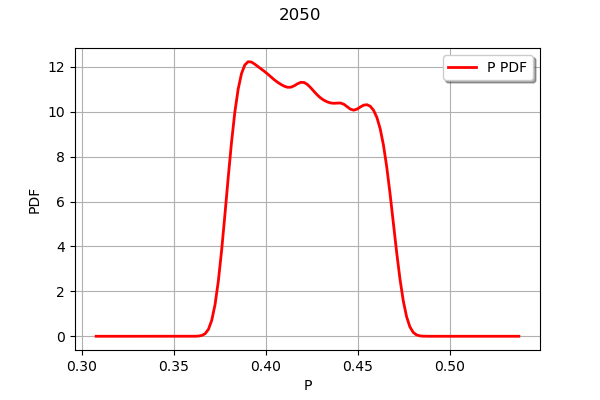

In [21]:
graph = fittedDist.drawPDF()
graph.setTitle("%d" % (annee))
graph